<a href="https://colab.research.google.com/github/PrusC/cvr_course/blob/main/notebooks/nn_sem5_pt2_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Все решение кроме импортов библиотек содержится после описания домашнего задания.

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Domik Dataset

In [4]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [ ]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [ ]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

In [ ]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

## Train

In [ ]:
EPOCHS_TO_TRAIN = 3
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

In [ ]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes


In [ ]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

In [ ]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

## Train

In [ ]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.1))

## Test

In [ ]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [ ]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [ ]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

In [ ]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

## Train

In [ ]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.001))

## Test

In [ ]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

# Train Function

In [154]:
def train(network, train_dataset, epochs, criterion, optimizer, is_print=True):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        if is_print:
            print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)
    if not is_print:
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test Function

In [12]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# Test Multiple Function

In [89]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# Часть1
- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл

# Domik Dataset

In [ ]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

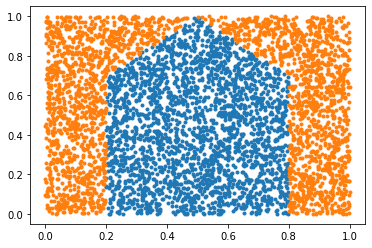

In [37]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)
data = DataLoader(domik, batch_size=1)
domik.show()

# 2 Layet Net

In [72]:
class Net2Layer(nn.Module):

    def __init__(self):
        super(Net2Layer, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # x = F.leaky_relu(self.fc1(x))
        # x = F.leaky_relu(self.fc2(x))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

Net2Layer(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch      199 Loss: 0.04232316237341246


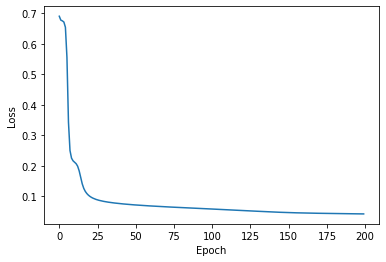

In [76]:
net1 = Net2Layer().float().to(device)
print(net1)

EPOCHS_TO_TRAIN = 200
train(network=net1, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.BCELoss(), 
      optimizer=optim.SGD(net1.parameters(), lr=0.05),
      is_print=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network on the 25000 test samples: 98.296


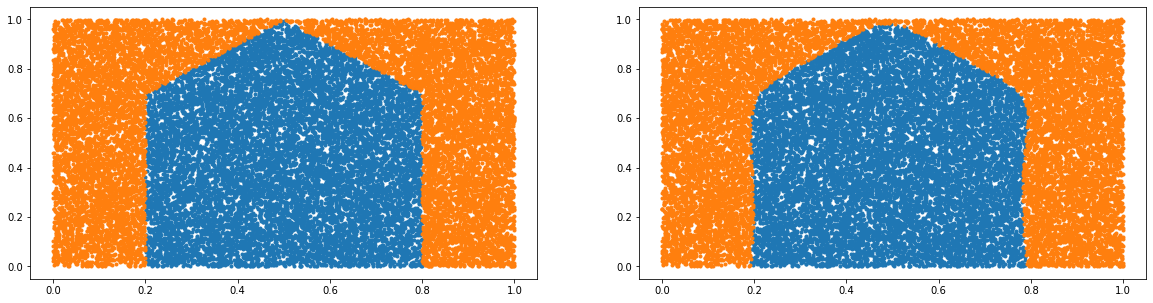

In [77]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net1, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

--------------------------------------------------------------------------------

# Часть 2

- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл

# Domik dataset for multi classes

In [78]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

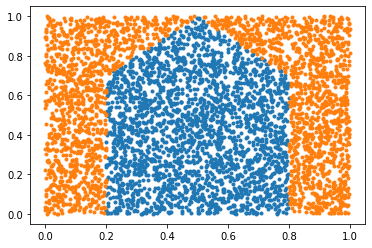

In [80]:
DATASET_SIZE = 5000
domik2 = MultiClassDomikDataset(DATASET_SIZE)
data2 = DataLoader(domik2, batch_size=1)
domik2.show()

# 2 Layer Net for Multi Class

In [101]:
class Net2LayerMultiClass(nn.Module):

    def __init__(self):
        super(Net2LayerMultiClass, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        return x

Net2LayerMultiClass(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)
Epoch       99 Loss: 0.03949837099346702


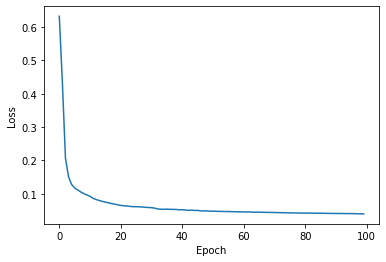

In [95]:
net2 = Net2LayerMultiClass().float().to(device)
print(net2)

EPOCHS_TO_TRAIN = 100
train(network=net2, 
      train_dataset=data2, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net2.parameters(), lr=0.05),
      is_print=False)

Accuracy of the network on the 25000 test samples: 98.356


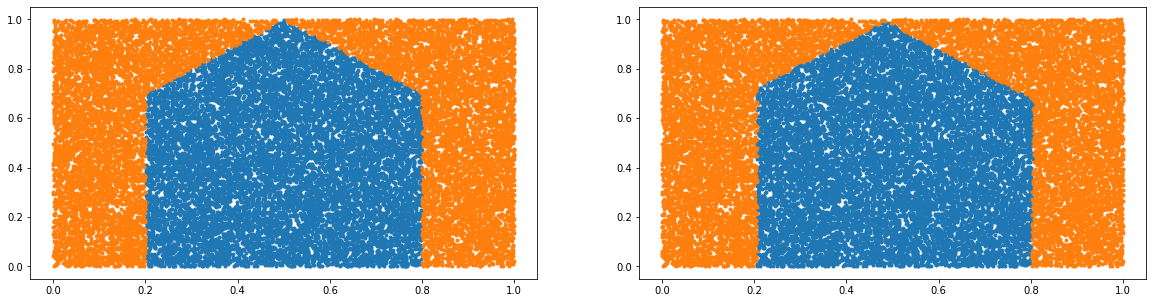

In [96]:
test_dataset2 = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net2, test_dataset=test_dataset2, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

------------------------------

# Часть 3

- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл

# Domik with window dataset

In [97]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

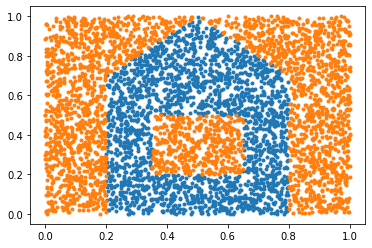

In [138]:
DATASET_SIZE = 5000
domik3 = WindowedDomikDataset(DATASET_SIZE)
data3 = DataLoader(domik3, batch_size=3)
domik3.show()

# 3 Layer Net

In [145]:
class Net3Layer(nn.Module):

    def __init__(self):
        super(Net3Layer, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        # x = F.sigmoid(self.fc3(x))
        return x

Net3Layer(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)
Epoch      199 Loss: 0.01889912839457499


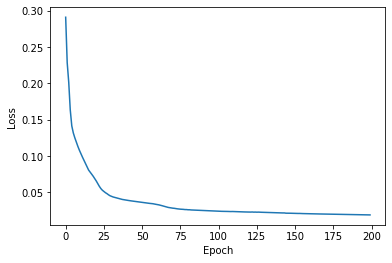

In [147]:
net3 = Net3Layer().float().to(device)
print(net3)

EPOCHS_TO_TRAIN = 200
train(network=net3, 
      train_dataset=data3, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net3.parameters(), lr=0.01),
      is_print=False)

Accuracy of the network on the 25000 test samples: 98.272


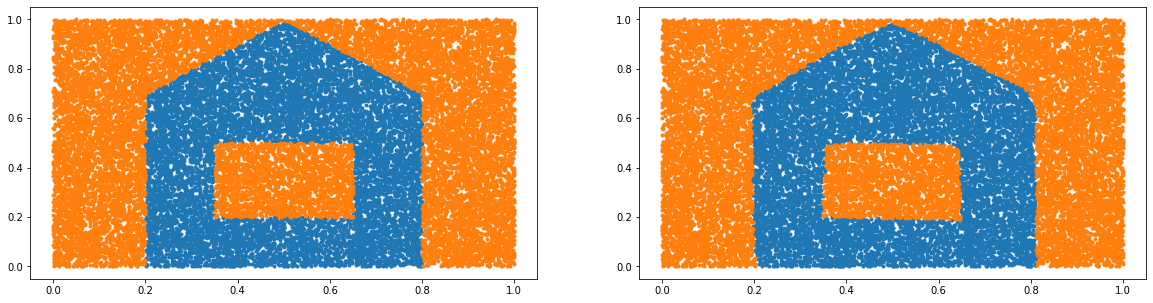

In [148]:
test_dataset3 = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net3, test_dataset=test_dataset3, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Часть 4

- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

## Domik with door and 2 windows dataset

In [163]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

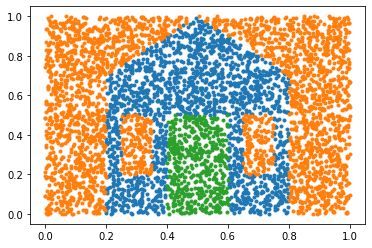

In [259]:
DATASET_SIZE = 5000
domik4 = DoorDomikDataset(DATASET_SIZE)
data4 = DataLoader(domik4, batch_size=12)
domik4.show()

## Net

In [260]:
class Net3LayerMultiClass(nn.Module):

    def __init__(self):
        super(Net3LayerMultiClass, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        # x = F.sigmoid(self.fc3(x))
        return x

In [273]:
net4 = Net3LayerMultiClass().float().to(device)
print(net4)

Net3LayerMultiClass(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)


## Train

Epoch      299 Loss: 0.12144779768251486


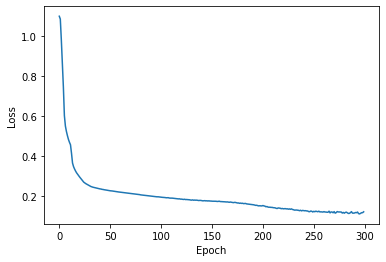

In [274]:
EPOCHS_TO_TRAIN = 300
train(network=net4, 
      train_dataset=data4, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net4.parameters(), lr=0.05),
      is_print=False)

Retrain with smaller lr

Epoch      299 Loss: 0.040126739877754794


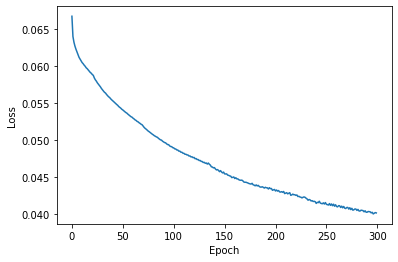

In [275]:
EPOCHS_TO_TRAIN = 300
train(network=net4, 
      train_dataset=data4, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net4.parameters(), lr=0.01),
      is_print=False)

## Test

In [242]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.076


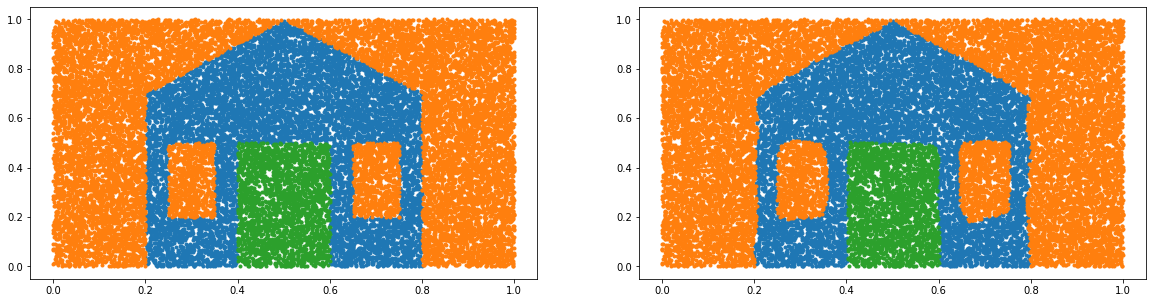

In [276]:
test_dataset4 = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net4, test_dataset=test_dataset4)